In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/Users/junwoopark/Downloads/python/SPT_a/andi_datasets/utils_videos.py:22: UserWarning: From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.
  warnings.warn('From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.')


In [126]:
model_num = 18

In [127]:
N = 10
T = 200
L = None

WINDOW_WIDTHS = np.arange(10, 100, 2)
SHIFT_WIDTH = 40
JUMP_D = 5

In [4]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [5]:
def make_signal(x_pos, y_pos, win_widths):
    all_vals = []
    for win_width in win_widths:
        if win_width >= len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.ones(int(win_width/2)) * 0, vals))
        vals = np.concatenate((vals, np.ones(int(win_width/2)) * 0))
        vals = np.array(vals)
        all_vals.append(vals)
    
    all_vals = np.array(all_vals) + 1e-7
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return all_vals, normalized_vals

In [6]:
def compress_signals(signals):
    compressed_signal = []
    nb_signal = signals.shape[1]
    
    for row in signals.transpose():
        nb_activ_window = np.sum(row >= 0)
        if nb_activ_window != 0:
            comp = np.sum(row[row >= 0]) / nb_activ_window
        else:
            comp = 1e-7
        compressed_signal.append(comp)
    compressed_signal = (np.array(compressed_signal) - float(np.min(compressed_signal))) / np.max(compressed_signal)
    return compressed_signal

In [7]:
def slice_data(signal_seq, jump_d, ext_width):
    slice_d = []
    indice = []
    for i in range(ext_width, signal_seq.shape[1] - ext_width, jump_d):
        crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        if crop.shape[1] != SHIFT_WIDTH:
            crop = np.hstack((crop, np.zeros((crop.shape[0], SHIFT_WIDTH - crop.shape[1])) ))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice) - ext_width

In [45]:
def merge_close_points(changepoints, signal, pred_probas, seuil=5):
    seq_sums = []
    #val_orders = np.argsort(np.sum(signal[:, changepoints], axis=0))[::-1]
    val_orders = np.argsort(pred_probas)[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [42]:
def signal_from_extended_data(x, y, win_widths, ext_width, jump_d):
    datas = []
    for data in [x, y]:
        delta_prev_data = -uncumulate(data[:min(data.shape[0], ext_width)])
        delta_prev_data[0] += float(data[0])
        prev_data = np.cumsum(delta_prev_data)[::-1]

        delta_next_data = -uncumulate(data[data.shape[0] - min(data.shape[0], ext_width):][::-1])
        delta_next_data[0] += float(data[-1])
        next_data = np.cumsum(delta_next_data)

        ext_data = np.concatenate((prev_data, data))
        ext_data = np.concatenate((ext_data, next_data))
        datas.append(ext_data)

    signal, norm_signal = make_signal(datas[0], datas[1], win_widths)
    sliced_signals, slice_indice = slice_data(signal, jump_d, min(data.shape[0], ext_width))

    return (signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
            norm_signal[:, delta_prev_data.shape[0]:signal.shape[1] - delta_next_data.shape[0]],
           sliced_signals,
           slice_indice,
           signal)

In [43]:
def ana_cp_predict(model, x, y, win_widths, jump_d, check_proba=False):
    cps = []
    if x.shape[0] <  win_widths[0]:
        return cps
    signal, norm_signal, input_signals, indice, ext_signal = signal_from_extended_data(x, y,
                                                                                       win_widths,
                                                                                       win_widths[-1]//2,
                                                                                       jump_d)
    #signal, norm_signal = make_signal(x, y, win_widths)
    #input_signals, indice = slice_data(signal, jump_d=jump_d)

    input_signals = np.array(input_signals).reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)
    
    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        #cps = indice[np.round(pred) >= 1]
        cps = indice[pred >= 0.5]

        if check_proba:
            for k, i in enumerate(range(0, x.shape[0], jump_d)):
                print(np.round(pred[k], 3), i, end='     ')
            print()
            

    if len(cps) == 0:
        return cps

    reg_inputs = input_signals[cps//jump_d,:,:,:]
    reg_inputs = np.array(reg_inputs).reshape(-1, signal.shape[0], SHIFT_WIDTH, 1)
    reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()

    if check_proba:
        print(np.hstack((cps, reg_outputs)).reshape(-1, 2))
    
    app_indice = np.argwhere(abs(reg_outputs) < jump_d*2).flatten()
    cps = cps[app_indice]
    reg_outputs = reg_outputs[app_indice]
    cps = np.round(cps + reg_outputs).astype(int)

    input_signals = []
    indices = []
    cps_doublecheck = []

    for cp_check in cps:
        if cp_check <= 0 or cp_check >= x.shape[0]:
            continue
        indices.append(cp_check)
        input_signals.append(ext_signal[:, min(x.shape[0], win_widths[-1]//2) + cp_check - SHIFT_WIDTH//2:
                              min(x.shape[0], win_widths[-1]//2) + cp_check + SHIFT_WIDTH//2])

    if len(indices) == 0:
        return []
        
    input_signals = np.array(input_signals)
    input_signals = input_signals.reshape(-1, input_signals.shape[1], SHIFT_WIDTH, 1)
    feat1 = np.array([np.mean(signal, axis=1)**2 / np.std(signal, axis=1)**2] * input_signals.shape[0])
    feat1 = feat1.reshape(-1, input_signals.shape[1], 1, 1)

    if input_signals.shape[0] != 0:
        pred = model.predict([input_signals, feat1], verbose=0).flatten()
        cps_doublecheck = np.array(indices)[np.argwhere(pred >= 0.5).flatten()]
        pred_probas = pred[np.argwhere(pred >= 0.5).flatten()]
        
    if len(cps_doublecheck) > 0:
        cps_doublecheck = merge_close_points(np.array(cps_doublecheck), signal, pred_probas, seuil=10)
    return np.sort(cps_doublecheck)

In [128]:
classification_model = tf.keras.models.load_model(f'./models/{model_num}/cls_model_{SHIFT_WIDTH}_2.keras')
regression_model = tf.keras.models.load_model(f'./models/{model_num}/reg_model_{SHIFT_WIDTH}_2.keras')

Trajectory legnth:  (200,)
0.049 0     0.007 5     0.004 10     0.015 15     0.014 20     0.017 25     0.051 30     0.06 35     0.095 40     0.127 45     0.069 50     0.062 55     0.165 60     0.052 65     0.051 70     0.035 75     0.062 80     0.786 85     0.552 90     0.12 95     0.072 100     0.06 105     0.057 110     0.023 115     0.1 120     0.052 125     0.012 130     0.003 135     0.005 140     0.003 145     0.001 150     0.002 155     0.028 160     0.092 165     0.069 170     0.127 175     0.069 180     0.319 185     0.099 190     0.125 195     
[[85.         90.        ]
 [ 1.07190204  1.06925368]]
CPS: [86]


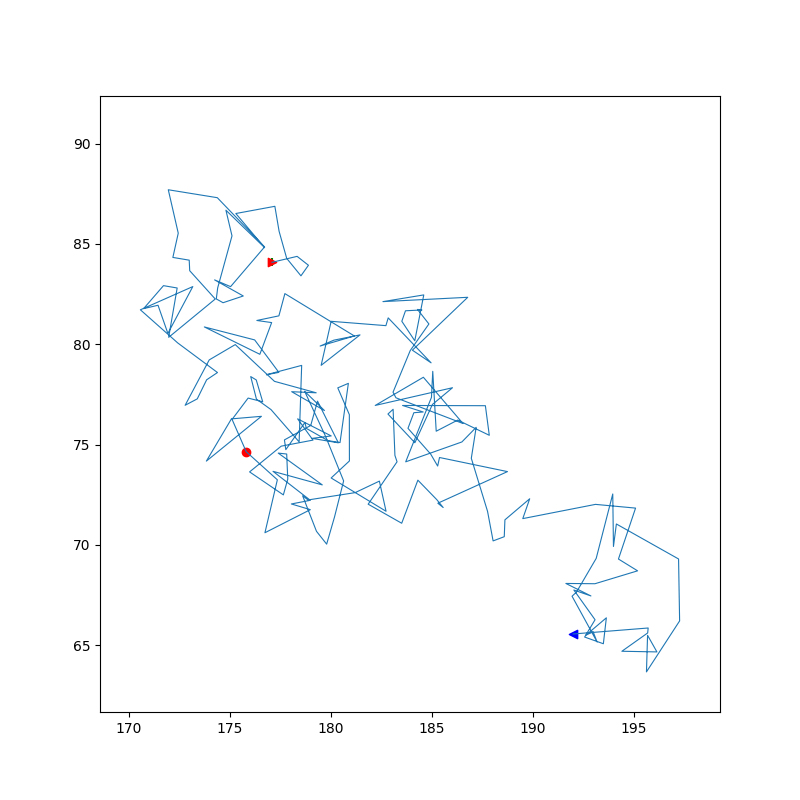

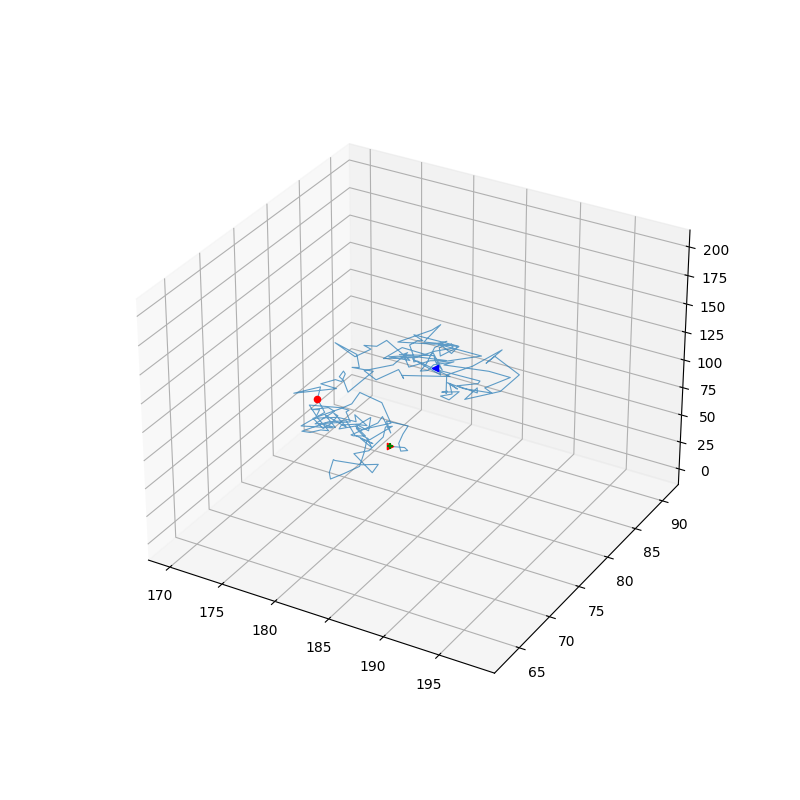

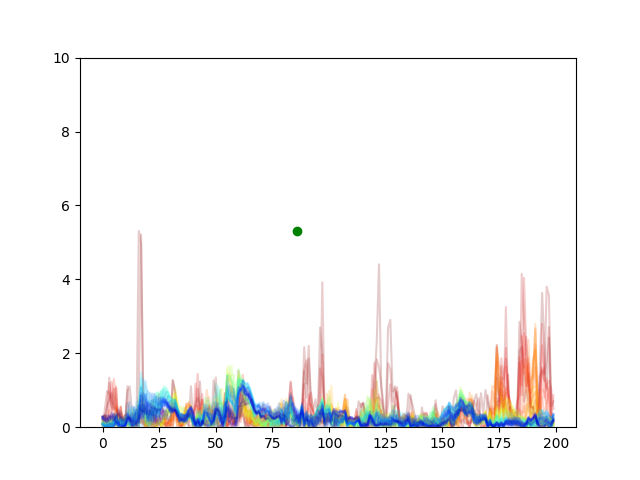

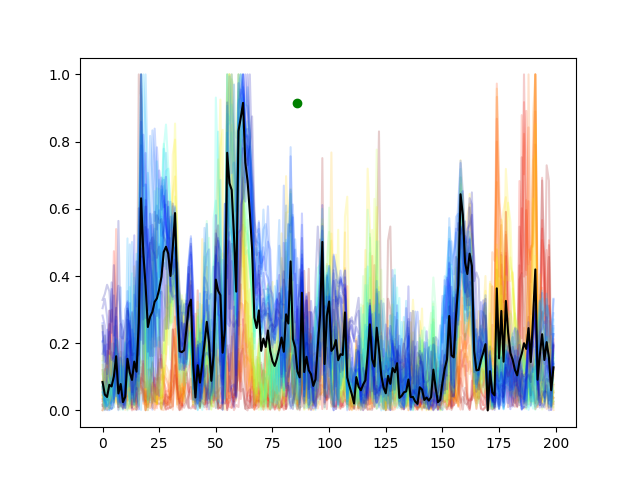

In [130]:
public_data_path = 'public_data_validation_v1/' # make sure the folder has this name or change it
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

track = 2
exp = 5
fovs = [0]
traj_idx = [33] # 0exp0fov of 3, 11, 13, 15, 16, 38, 46 check
checkpoints = [0]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')

    for idx in traj_idx:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        print('Trajectory legnth: ', x.shape)
        # Assign one changepoints for each traj at 0.25 of its length

        cps = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D, True)
        
        print(f'CPS: {cps}')
        
        signals, norm_signals, _ , _ , _ = signal_from_extended_data(x, y, 
                                                              WINDOW_WIDTHS, 
                                                              WINDOW_WIDTHS[-1]//2,
                                                             JUMP_D)

        plt.figure(figsize=(8, 8))
        plt.plot(x, y, linewidth=0.8)
        plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        for checkpoint in checkpoints:
            plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
        plt.scatter(x[0], y[0], marker='>', c='red')
        plt.scatter(x[-1], y[-1], marker='<', c='blue')
        
        for cp in cps:
            plt.scatter(x[cp], y[cp], c='red')
        plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
        for cp in cps:
            ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], c='red')

        ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
        ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
        ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
        for checkpoint in checkpoints:
            ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')

        plt.figure()
        for i in range(signals.shape[0]):
            plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.2,
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])
        plt.scatter(cps, np.array([np.max(signals)] * len(cps)), c='green')
        plt.ylim([0, max(10, np.max(signals))])
        
        plt.figure()
        for i in range(norm_signals.shape[0]):
            plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.2, 
                     label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])
        comp_signal = compress_signals(norm_signals)
        #plt.plot(np.arange(signals.shape[1]), comp_signal / SNR / np.max(comp_signal / SNR), c='red')
        plt.plot(np.arange(signals.shape[1]), comp_signal, c='black')
        plt.scatter(cps, np.array([np.max(comp_signal)] * len(cps)), c='green')


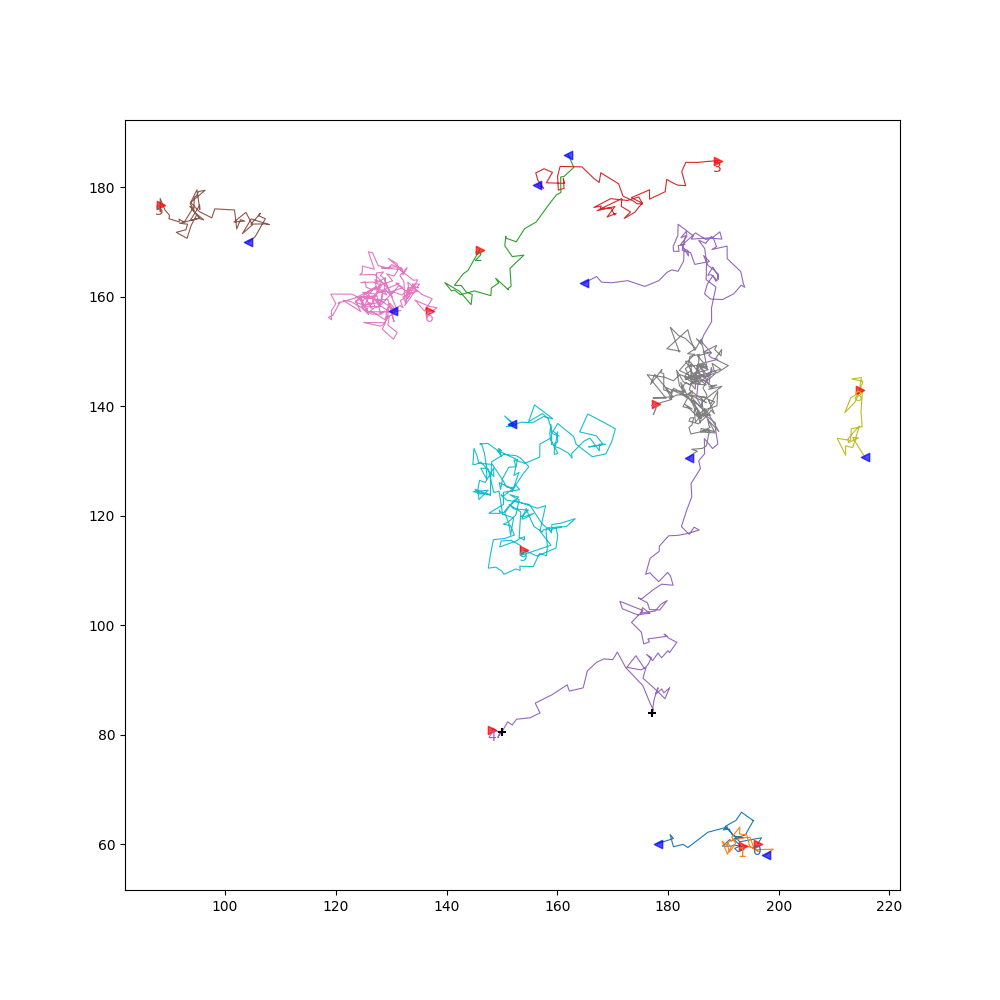

In [99]:
track = 2
exp = 5
fovs = [0]
check_indice = [0, 10]
        
for fov in fovs:
    # We read the corresponding csv file from the public data and extract the indices of the trajectories:
    if track == 2:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
    else:
        df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
    plt.figure(figsize=(10, 10))
    for idx in np.unique(df.traj_idx).astype(int)[check_indice[0]: check_indice[1]]:
        # Get the lenght of the trajectory
        x = np.array(df[df.traj_idx == idx])[:, 2]
        y = np.array(df[df.traj_idx == idx])[:, 3]
        length_traj = df[df.traj_idx == idx].shape[0]
        cps = ana_cp_predict(classification_model, x, y, WINDOW_WIDTHS, JUMP_D)

        trajectory = plt.plot(x, y, linewidth=0.8, zorder=0)
        plt.scatter(x[0], y[0], marker='>', c='red', zorder=1, alpha=0.7)
        plt.annotate(str(idx), xy=(x[0]-1,y[0]-2), color=trajectory[0].get_color())
        plt.scatter(x[-1], y[-1], marker='<', c='blue', zorder=1, alpha=0.7)
        for cp in cps:
            plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2) 


# Produce a trajectory and check signals

0.023 0     0.058 5     0.23 10     0.806 15     0.362 20     0.122 25     0.134 30     0.062 35     0.17 40     0.044 45     0.044 50     0.097 55     0.073 60     0.036 65     0.035 70     0.2 75     0.419 80     0.232 85     0.149 90     0.133 95     0.125 100     0.582 105     0.294 110     0.214 115     0.948 120     0.621 125     0.332 130     0.428 135     0.239 140     0.483 145     0.479 150     0.814 155     0.97 160     0.791 165     0.895 170     0.962 175     0.934 180     0.499 185     0.528 190     0.104 195     
[[ 15.         105.        ]
 [120.         125.        ]
 [155.         160.        ]
 [165.         170.        ]
 [175.         180.        ]
 [190.           1.23365009]
 [  1.20060253   1.12963593]
 [  1.11769342   1.15924048]
 [  1.11522436   1.12105691]
 [  1.14224696   1.16635239]
 [  1.12861824   1.05774307]]
GT: [ 35  47 120 147 180]
Pred: [ 16 121 156 176]


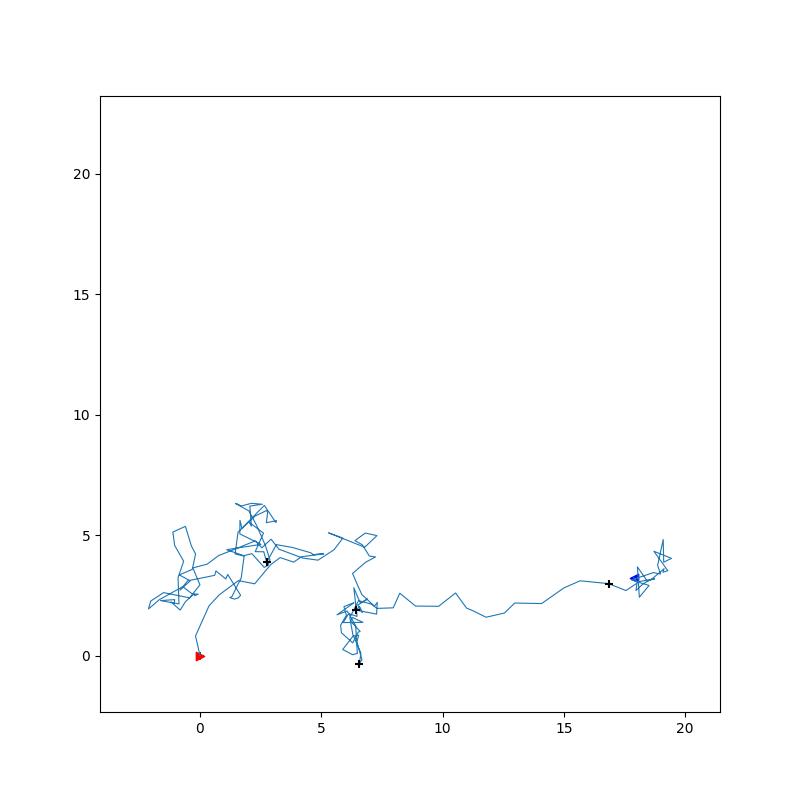

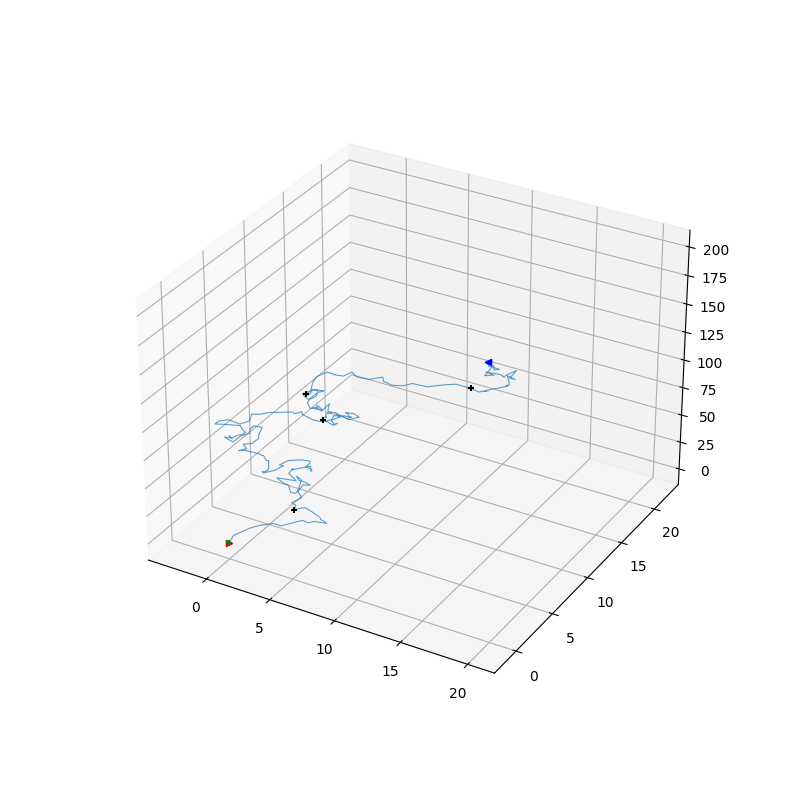

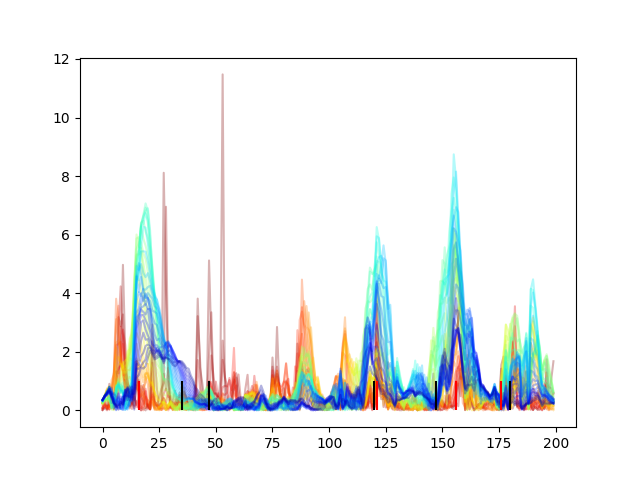

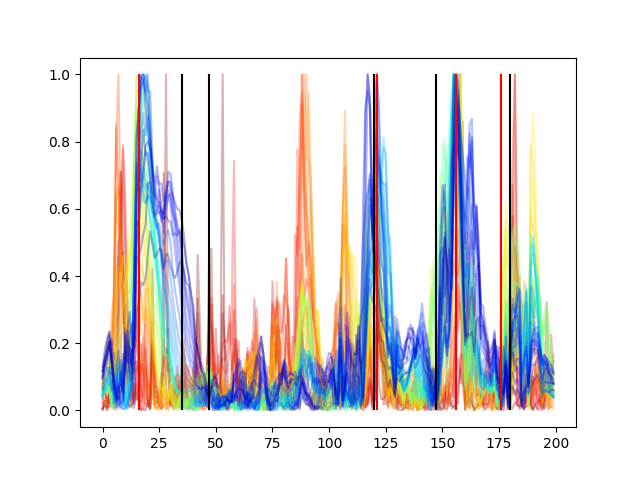

In [48]:
trajs_model, labels_model = models_phenom().multi_state(N=2,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.7, 1.4],
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],
                                                        M=[[0.99, 0.01], [0.01, 0.99]]
                                                       )
signal_seq = make_signal(trajs_model[:, 0, 0], trajs_model[:, 0, 1], WINDOW_WIDTHS)
changepoints, alphas_cp, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
cps = ana_cp_predict(classification_model,
                     trajs_model[:, 0, 0],
                     trajs_model[:, 0, 1],
                     WINDOW_WIDTHS,
                     JUMP_D,
                    True)

changepoints = changepoints[:-1]
print(f'GT: {changepoints}')
print(f'Pred: {cps}')

%matplotlib widget
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]
        
x = trajs_model[:, 0, 0]
y = trajs_model[:, 0, 1]

signals, norm_signals, _ , _ , _ = signal_from_extended_data(x, y,
                                                             WINDOW_WIDTHS,
                                                             WINDOW_WIDTHS[-1]//2,
                                                             JUMP_D)
plt.figure(figsize=(8, 8))
plt.plot(x, y, linewidth=0.8)
plt.xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
plt.scatter(x[checkpoint], y[checkpoint], marker='+', c='green')
plt.scatter(x[0], y[0], marker='>', c='red')
plt.scatter(x[-1], y[-1], marker='<', c='blue')
for cp in cps:
    plt.scatter(x[cp], y[cp], marker='+', c='black', zorder=2)

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(x, y, np.arange(signals.shape[1]), linewidth=0.8, alpha=0.7)
ax.set_xlim([np.min(x) - 2,
                  np.min(x) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.set_ylim([np.min(y) - 2,
                  np.min(y) + max(np.max(x) - np.min(x), 
                    np.max(y) - np.min(y)) + 2])
ax.scatter3D(x[0], y[0], 0, marker='>', c='red')
ax.scatter3D(x[-1], y[-1], signals.shape[1], marker='<', c='blue')
ax.scatter3D(x[checkpoint], y[checkpoint], np.arange(signals.shape[1])[checkpoint], marker='+', c='green')
for cp in cps:
    ax.scatter3D(x[cp], y[cp], np.arange(signals.shape[1])[cp], marker='+', c='black', zorder=2)

plt.figure()
for i in range(signals.shape[0]):
    plt.plot(np.arange(signals.shape[1]), signals[i], alpha=0.3,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='black')

for cp in cps:
    plt.vlines(cp, 0, 1, color='red')

        
plt.figure()
for i in range(norm_signals.shape[0]):
    plt.plot(np.arange(norm_signals.shape[1]), norm_signals[i], alpha=0.3,
             label=f'{WINDOW_WIDTHS[i]}', c=color_seq[int(i * 255 / norm_signals.shape[0])])

for cp in changepoints:
    plt.vlines(cp, 0, 1, color='black')

for cp in cps:
    plt.vlines(cp, 0, 1, color='red')
